In [ ]:
!pip install wordcloud

In [1]:
!pip install --upgrade transformers jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 5.7 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset

from tqdm.notebook import tqdm

from transformers import BertTokenizer

In [2]:
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dt = pd.read_csv('/content/drive/MyDrive/Competitions/ЦП СФО/TRAIN_RES_1.csv')
dt.head(5)

,achievements,achievements_modified,company_name,demands,id_cv,job_title
0,NaN,NaN,Управление социальной защиты населения Сердобс...,"Работала,непосредственно, с федеральными льгот...",52860148-26da-11e8-a184-9122a281f90e,инспектор
1,NaN,NaN,Администрация города Сердобска,Работа с реестром муниципальной собственности,52860148-26da-11e8-a184-9122a281f90e,инспектор
2,"Работы не закончены, т.к. нет настоящего желан...","Работы не закончены, т.к. нет настоящего желан...",январь 2016-настоящее времяООО «АРТЕЛЬ СТАРАТЕ...,Курирую работы по рудному направлению: соавтор...,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог
3,NaN,NaN,"ОАО «Васильевский рудник», п.Мотыгино, Красноя...",ГРП. Документация керна разведочных скважин,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог
4,NaN,NaN,"ООО «Артель старателей «ТАЛ»», Усть-Нера, Респ...",Поисково-разведочные работы на месторождении р...,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог


In [5]:
dt.size

12000000

In [6]:
dt = dt[:200000]

In [7]:
dt.size

1200000

## EDA

In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   achievements           37618 non-null   object
 1   achievements_modified  37618 non-null   object
 2   company_name           199952 non-null  object
 3   demands                199058 non-null  object
 4   id_cv                  200000 non-null  object
 5   job_title              200000 non-null  object
dtypes: object(6)
memory usage: 9.2+ MB


In [ ]:
dt.describe()

,achievements,achievements_modified,company_name,demands,id_cv,job_title
count,37618,37618,199952,199058,200000,200000
unique,26875,26861,130444,147245,89955,965
top,успешное выполнение своих обязанностей,нет,ПАО Сбербанк,Согласно должностной инструкции,fc7187c0-a5e6-11e8-b833-ef76bd2a03c1,специалист
freq,154,157,641,221,27,22143


In [ ]:
print("\nКоличество уникальных значений в каждом столбце:")
for col in dt.columns:
    print(f"{col}: {dt[col].nunique()}")


Количество уникальных значений в каждом столбце:
achievements: 26875
achievements_modified: 26861
company_name: 130444
demands: 147245
id_cv: 89955
job_title: 965


In [ ]:
missing_values = dt.isnull().sum()
print("\nПропущенные значения в данных:")
print(missing_values)


Пропущенные значения в данных:
achievements             162382
achievements_modified    162382
company_name                 48
demands                     942
id_cv                         0
job_title                     0
dtype: int64



Распределение значений для job_title:
job_title
специалист                          51767
инженер                             31836
бухгалтер                           31183
менеджер                            30103
оператор                            19804
                                    ...  
драгер                                  1
заправщик поливомоечных машин           1
паркетчик                               1
составитель химических растворов        1
давильщик                               1
Name: count, Length: 1243, dtype: int64


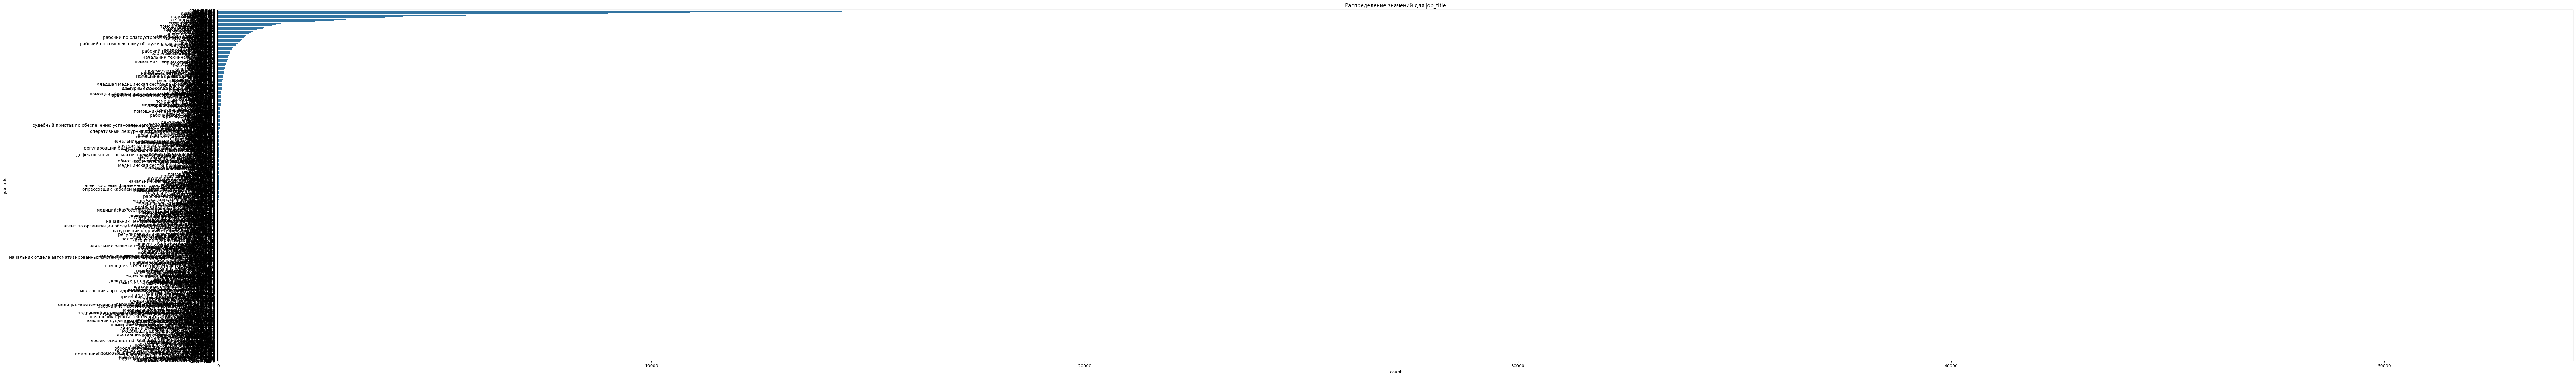


Распределение значений для company_name:
company_name
ПАО Сбербанк                                                                                                      1574
ИП                                                                                                                 795
ОАО РЖД                                                                                                            704
Почта России                                                                                                       649
ФГУП Почта России                                                                                                  595
                                                                                                                  ... 
Муниципальное бюджетное общеобразовательное учреждение "Начальная общеобразовательная школа №95" г. Челябинска       1
ООО Книжный клуб "Клуб семейного досуга"                                                                        

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7ae3d596b1c0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ae3d596a440> (for post_execute):


KeyboardInterrupt: 

In [ ]:
categorical_columns = ['job_title', 'company_name']
for col in categorical_columns:
    print(f"\nРаспределение значений для {col}:")
    print(dt[col].value_counts())
    plt.figure(figsize=(40, 25))
    sns.countplot(y=dt[col], order=dt[col].value_counts().index)
    plt.title(f'Распределение значений для {col}')
    plt.show()

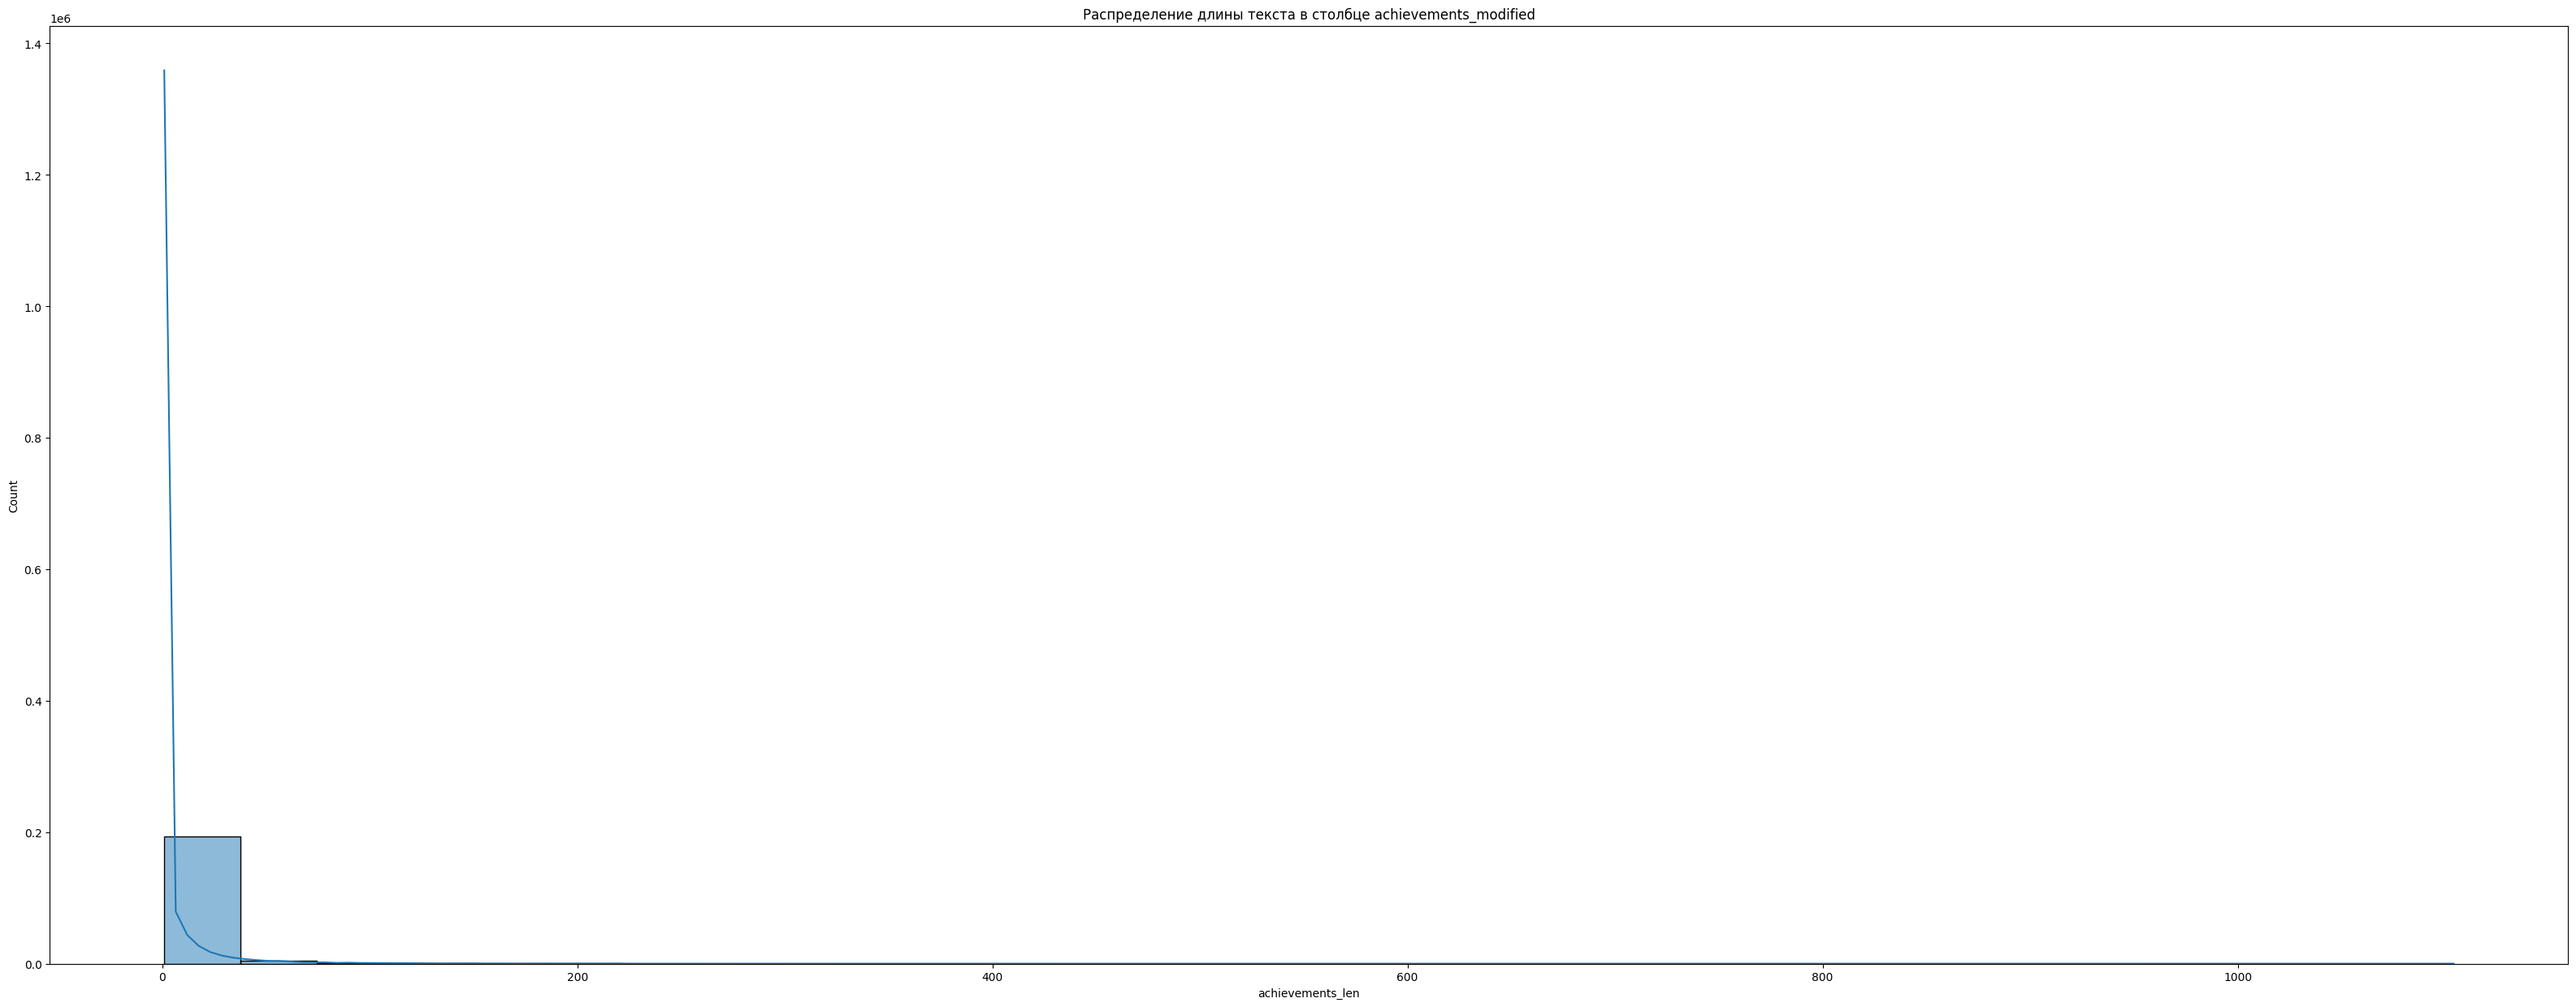

In [ ]:
dt['achievements_len'] = dt['achievements_modified'].apply(lambda x: len(str(x).split()))
dt['demands_len'] = dt['demands'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(40, 15))
sns.histplot(dt['achievements_len'], bins=30, kde=True)
plt.title('Распределение длины текста в столбце achievements_modified')
plt.show()

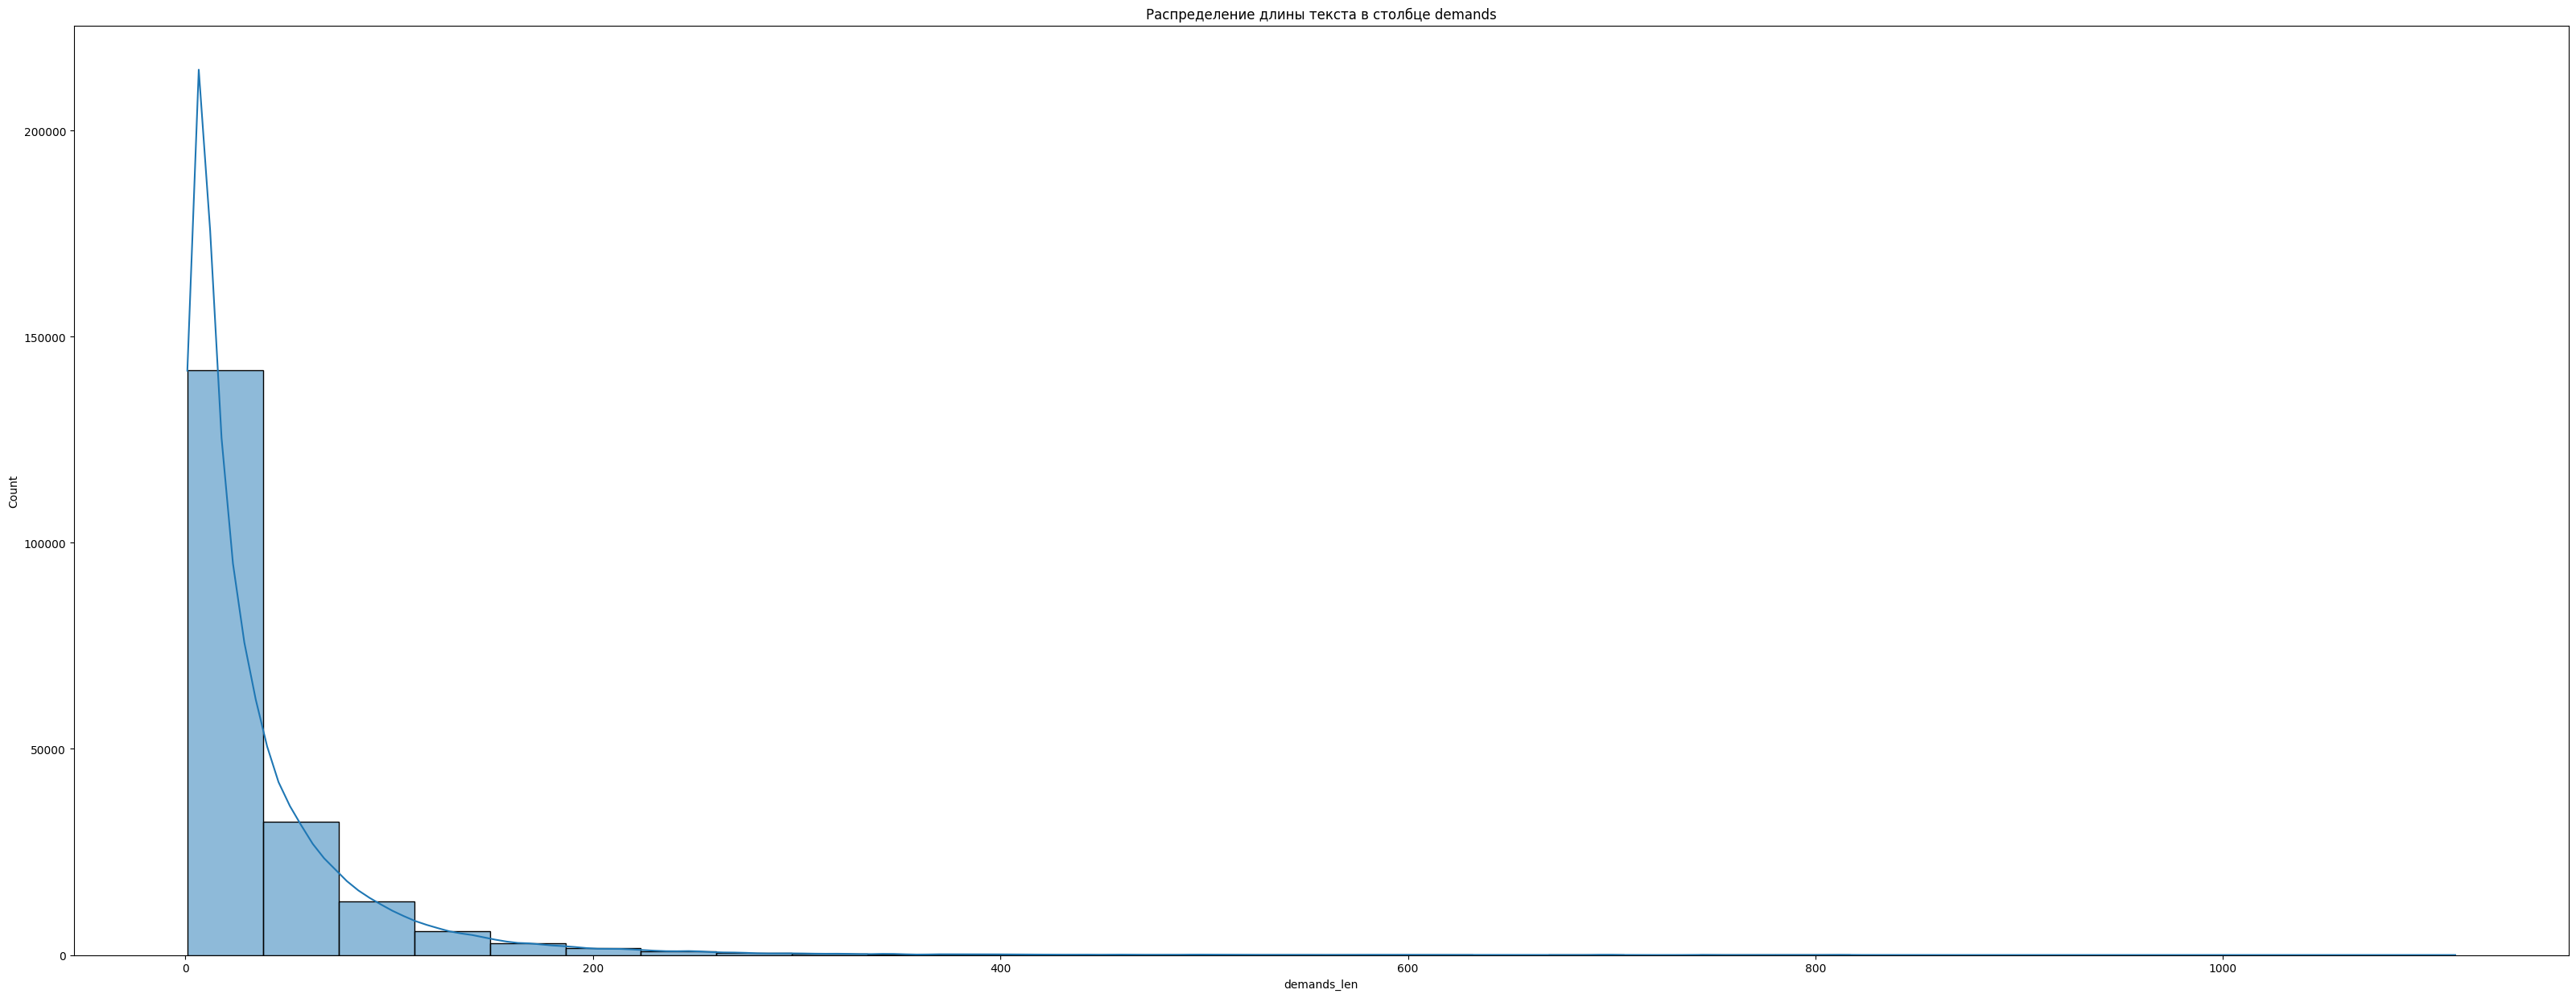

In [ ]:
plt.figure(figsize=(40, 15))
sns.histplot(dt['demands_len'], bins=30, kde=True)
plt.title('Распределение длины текста в столбце demands')
plt.show()

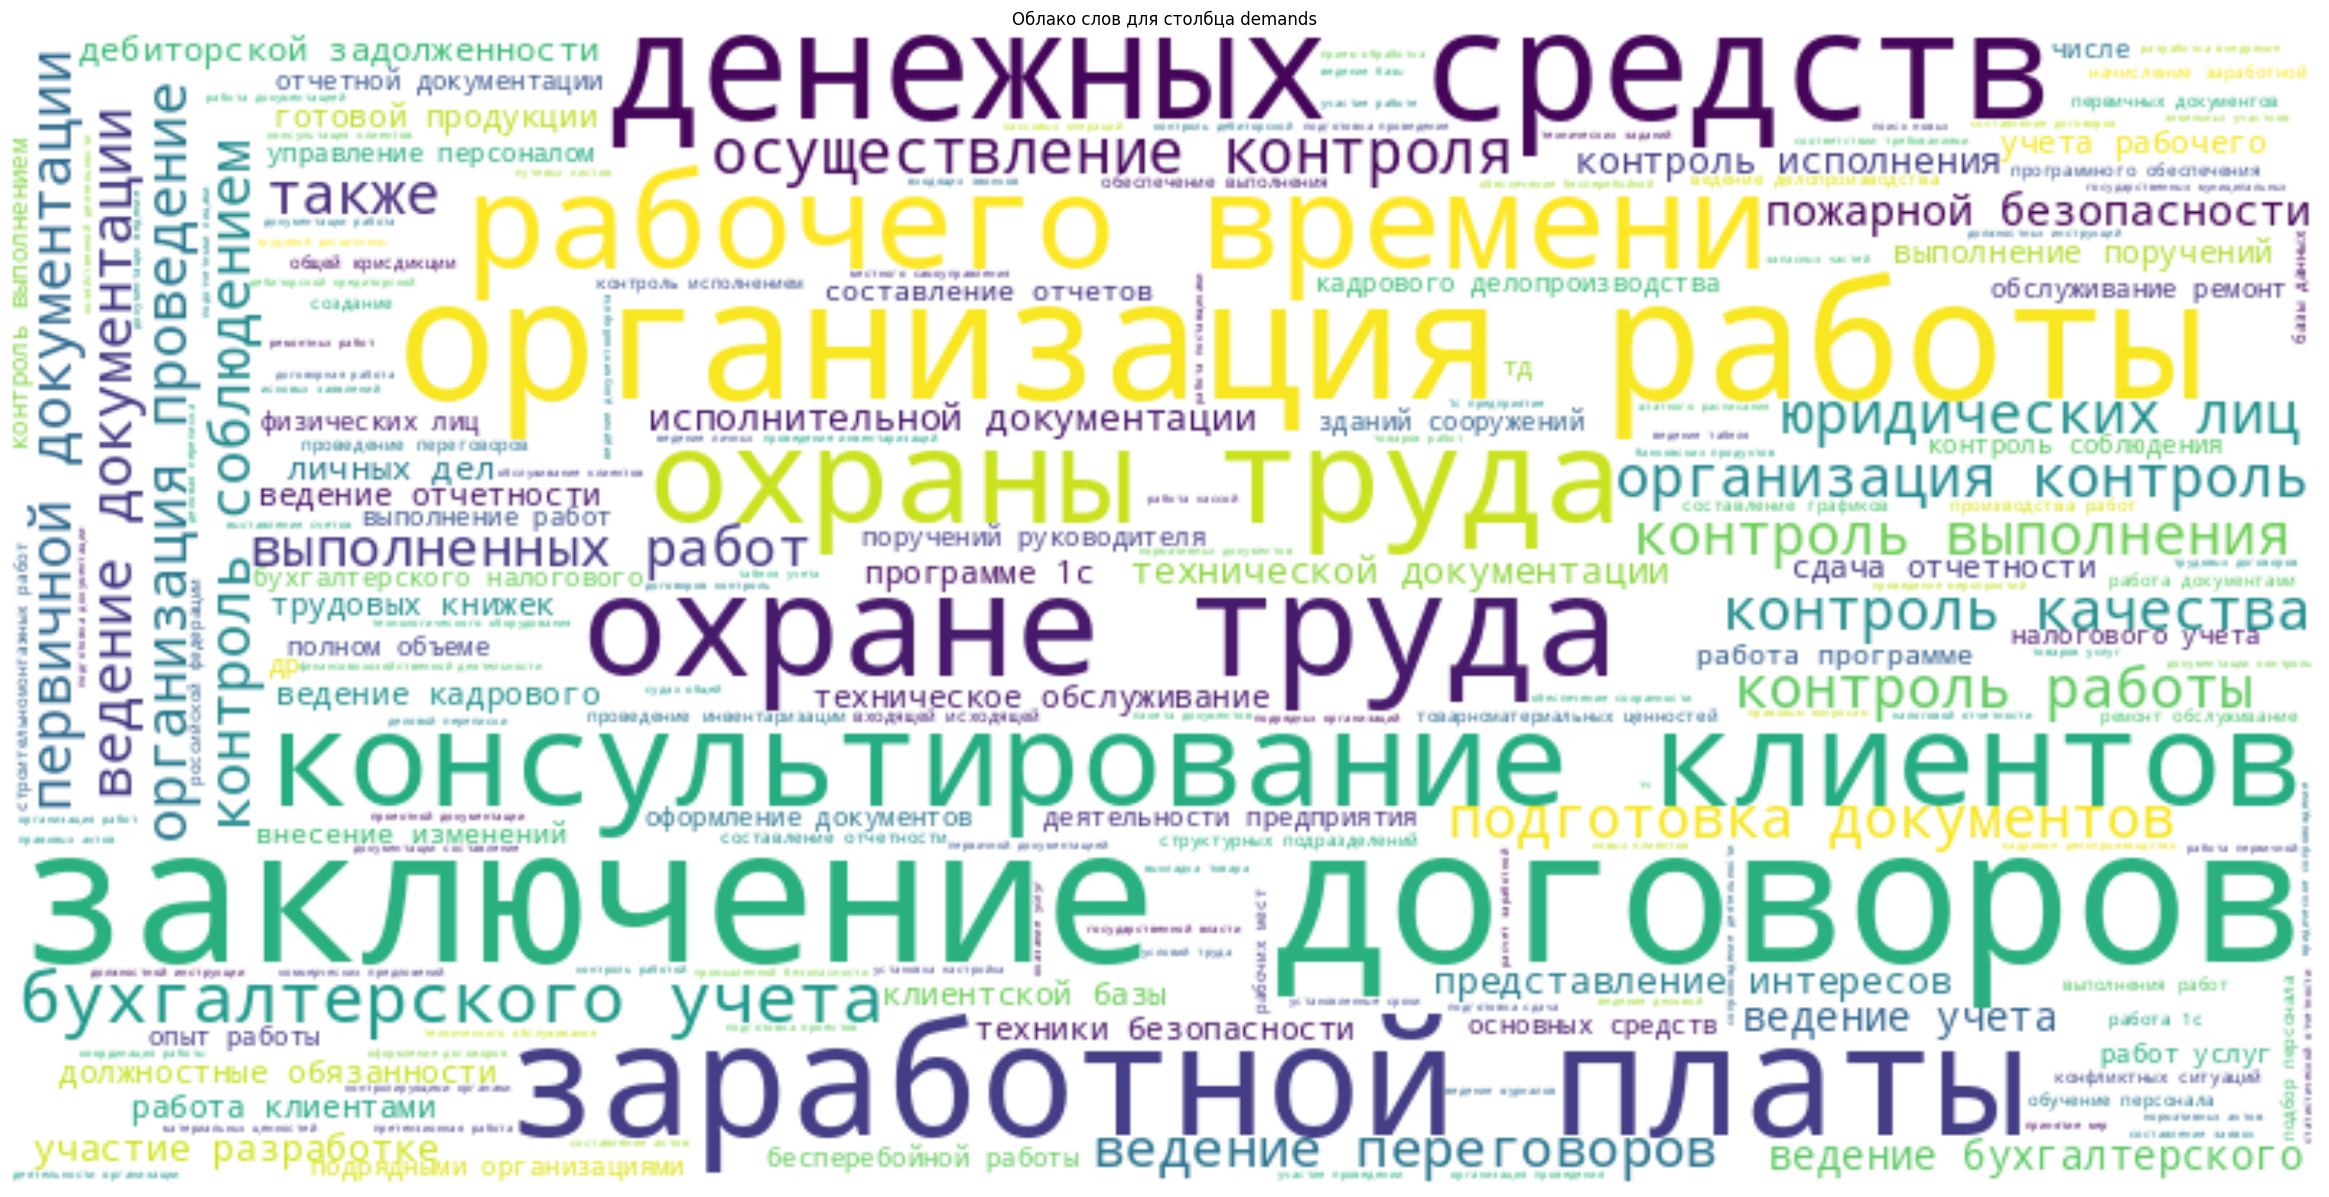

In [ ]:
all_text = ' '.join(dt['demands'].dropna().astype(str).tolist())

# Очистим текст от пунктуации и стоп-слов
all_text = all_text.lower().translate(str.maketrans('', '', string.punctuation))  # Удаление пунктуации
all_text = ' '.join([word for word in all_text.split() if word not in russian_stopwords])  # Удаление стоп-слов

# Создадим объект WordCloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_text)

# Построим график облака слов
plt.figure(figsize=(40, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для столбца demands')
plt.show()

## Baseline solution with ruBERT

### Data preprocessing

In [8]:
target_column = 'job_title'  # Столбец с названиями должностей
text_columns = ['achievements_modified', 'demands', 'company_name']  # Текстовые столбцы

In [9]:
dt['text'] = dt[text_columns].fillna('').apply(lambda x: '. '.join(x), axis=1)

In [10]:
dt.head()

,achievements,achievements_modified,company_name,demands,id_cv,job_title,text
0,NaN,NaN,Управление социальной защиты населения Сердобс...,"Работала,непосредственно, с федеральными льгот...",52860148-26da-11e8-a184-9122a281f90e,инспектор,". Работала,непосредственно, с федеральными льг..."
1,NaN,NaN,Администрация города Сердобска,Работа с реестром муниципальной собственности,52860148-26da-11e8-a184-9122a281f90e,инспектор,. Работа с реестром муниципальной собственност...
2,"Работы не закончены, т.к. нет настоящего желан...","Работы не закончены, т.к. нет настоящего желан...",январь 2016-настоящее времяООО «АРТЕЛЬ СТАРАТЕ...,Курирую работы по рудному направлению: соавтор...,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог,"Работы не закончены, т.к. нет настоящего желан..."
3,NaN,NaN,"ОАО «Васильевский рудник», п.Мотыгино, Красноя...",ГРП. Документация керна разведочных скважин,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог,. ГРП. Документация керна разведочных скважин....
4,NaN,NaN,"ООО «Артель старателей «ТАЛ»», Усть-Нера, Респ...",Поисково-разведочные работы на месторождении р...,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог,. Поисково-разведочные работы на месторождении...


In [11]:
dt['text'][0]

'. Работала,непосредственно, с федеральными льготники.Вела приём граждан как по федеральным, так и по региональным льготам.Прием необходимых документов.Обработка и подшивка личных дел граждан.Работа с картотекой и архивом. Управление социальной защиты населения Сердобского района'

In [12]:
# Превращаем job_title в числовые метки
dt['label'] = pd.factorize(dt[target_column])[0]  # Преобразуем должности в цифры
num_labels = len(dt['label'].unique())  # Количество уникальных классов
num_labels

965

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
train_texts, val_texts, train_labels, val_labels = train_test_split(dt['text'], dt['label'], test_size=0.2, random_state=42)

In [15]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
train_texts = train_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
train_texts.dropna(inplace=True)
train_labels.dropna(inplace=True)
val_texts.dropna(inplace=True)
val_labels.dropna(inplace=True)

# Проверка на совпадение длины
assert len(train_texts) == len(train_labels), "Несоответствие количества текстов и меток!"

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

In [17]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        self.labels = self.labels.reset_index(drop=True)
        assert len(self.labels) == len(self.encodings['input_ids']), "Метки и данные имеют разную длину"

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Проверим наличие индексов
        assert idx < len(self.labels), f"Индекс {idx} вне диапазона!"
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).to(device)
        return item

# Создаем датасеты
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

In [18]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)

In [19]:
print(train_texts[:5])
print(train_labels[:5])

0    Изучил техническую часть банкоматов и терминал...
1    . - Консультирование клиентов/заёмщиков по воп...
2    . &Oslash| планирование хозяйственной деятельн...
3    . Обслуживание и ремонт домовых и придомовых т...
4    . Работа на Всероссийской студенческой стройки...
Name: text, dtype: object
0    280
1     70
2     53
3    686
4     20
Name: label, dtype: int64


In [20]:
assert len(train_encodings['input_ids']) == len(train_labels), "Количество токенов не совпадает с количеством меток!"

In [21]:
model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2', num_labels=num_labels)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [22]:
# Настройка обучения
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)

# Обучение модели
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.809500,2.757869
2,2.457400,2.424649
3,2.254500,2.347017


TrainOutput(global_step=30000, training_loss=2.7754307657877604, metrics={'train_runtime': 1960.7872, 'train_samples_per_second': 244.8, 'train_steps_per_second': 15.3, 'total_flos': 996019937280000.0, 'train_loss': 2.7754307657877604, 'epoch': 3.0})

In [23]:
model.eval()

all_preds = []
all_labels = []

# Проходим по валидационным данным
with torch.no_grad():
    for batch in tqdm(val_loader):
        # Загружаем данные на устройство (GPU/CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Получаем предсказания
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Преобразуем логиты в предсказанные метки
        preds = torch.argmax(logits, dim=-1)

        # Собираем все предсказания и реальные метки для последующей оценки
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Вычисляем F1-score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1-score: {f1}")

  0%|          | 0/2500 [00:00<?, ?it/s]

F1-score: 0.3898622073062369


In [ ]:
save_path = '/content/drive/MyDrive/bert_model'

# Сохранение модели и токенизатора
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Модель и токенизатор сохранены по пути: {save_path}")